# Coronavirus propagation visualization and forecast modeling. Part 1: History of Coronavirus.

### data processing _corona.ipynb 실행

존스 홉킨스 CSSE(Centers for Systems Science and Engineering)에서 실시간으로 신종 코로나 바이러스 (2019-nCoV)의 전 세계 현황을 보여주는 대쉬보드를 운영 중이다. 
(https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) 

 대쉬보드에서는 코로나 바이러스 확진자 수와 사망자 및 완치환자 수를 국가/지역별로 확인할 수 있다. 이 대시보드는 미국 질병통제예방센터, 세계보건기구, 유럽질병예방센터, 중국질병통제센터, 중국국가보건위원회와 CCDC의 자료를 집계한 중국 웹사이트 DXY로부터 데이터를 수집한다.

DataSet
https://github.com/CSSEGISandData/COVID-19
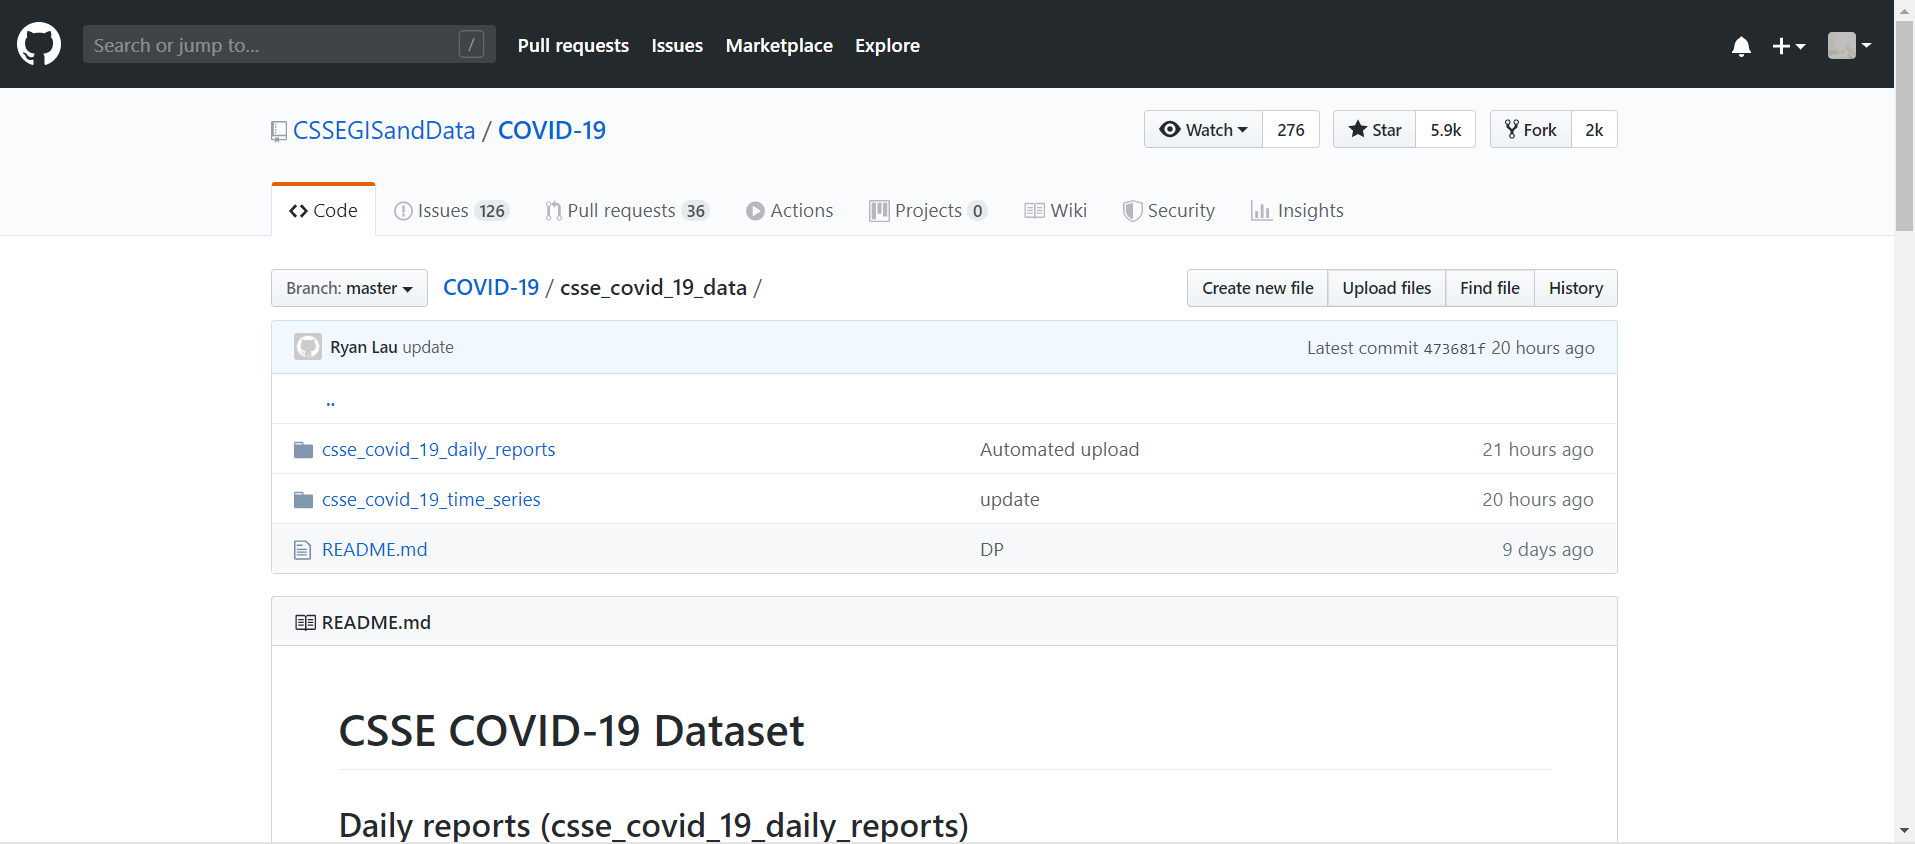

### Imports

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import math
from collections import namedtuple

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, TimestampedGeoJson
from folium.plugins import MiniMap

import datetime
import os


import json

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [3]:
# import os
# for dirname, _, filenames in os.walk('../bokeh-app/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
# df = pd.read_csv('../bokeh-app/input/dataset/2019_nCoV_20200121_20200127.csv')
# df = pd.read_csv("C:/Users/MSI/Untitled Folder/result.csv",  'rt', encoding='UTF8')
df = pd.read_csv("C:/Users/MSI/Untitled Folder/result.csv")
GEO_DATA = "../bokeh-app/input/geo"
cn_geo_path = "../bokeh-app/input/geo/china.json"
cn_geo_data = json.load(open(cn_geo_path, encoding='utf-8'))

df_rec = pd.read_csv('../bokeh-app/input/coronavirus-latlon-dataset/CV_LL_recovered.csv')
df_con = pd.read_csv('../bokeh-app/input/coronavirus-latlon-dataset/CV_LL_confirmed.csv')
df_death= pd.read_csv('../bokeh-app/input/coronavirus-latlon-dataset/CV_LL_death.csv')

In [5]:
df_con.head()

Unnamed: 0 Province/State Country/Region      Lat       Lon         Date  \
0           0          Anhui          China  31.8257  117.2264  01-22-2020    
1           1        Beijing          China  40.1824  116.4142  01-22-2020    
2           2      Chongqing          China  30.0572  107.8740  01-22-2020    
3           3         Fujian          China  26.0789  117.9874  01-22-2020    
4           4          Gansu          China  36.0611  103.8343  01-22-2020    

   Confirmed  Last Update  
0        1.0          NaN  
1       14.0          NaN  
2        6.0          NaN  
3        1.0          NaN  
4        NaN          NaN

In [6]:
def prepare_df(df):
    # turning date field into timestamps
    df['Last Update'] = pd.to_datetime(df['Last Update'])
    # geocoding does not know about 'Mainland China', so lets fix it into an API acceptable form
    df.loc[df['Country/Region'] == 'Mainland China', 'Country/Region'] = 'China'
    # also geocoding does not like deal with NAs
    df['Province/State'] = df['Province/State'].fillna(0)
    df['Confirmed'] = df['Confirmed'].fillna(0)
    return df

def prepare_df_date(df):
    # turning date field into timestamps
    df['Date'] = pd.to_datetime(df['Date'])
    # geocoding does not know about 'Mainland China', so lets fix it into an API acceptable form
    df.loc[df['Country/Region'] == 'Mainland China', 'Country/Region'] = 'China'
    # also geocoding does not like deal with NAs
    df['Province/State'] = df['Province/State'].fillna(0)
    return df

In [7]:
# df = prepare_df(df)
df_rec = prepare_df_date(df_rec)
df_con = prepare_df_date(df_con)
# df_con = prepare_df(df_con)
df_death = prepare_df_date(df_death)

In [8]:
df_con.head()

Unnamed: 0 Province/State Country/Region      Lat       Lon       Date  \
0           0          Anhui          China  31.8257  117.2264 2020-01-22   
1           1        Beijing          China  40.1824  116.4142 2020-01-22   
2           2      Chongqing          China  30.0572  107.8740 2020-01-22   
3           3         Fujian          China  26.0789  117.9874 2020-01-22   
4           4          Gansu          China  36.0611  103.8343 2020-01-22   

   Confirmed  Last Update  
0        1.0          NaN  
1       14.0          NaN  
2        6.0          NaN  
3        1.0          NaN  
4        NaN          NaN

In [9]:
# # dummy fields for lat and longitude
# df['lat'] = 0
# df['lon'] = 0

In [10]:
# just downloading the dataset, which has all the necessary data already
# df = pd.read_csv("../bokeh-app/input/coronavirus-latlon-dataset/coronavirus_cleaned_21Jan2Feb.csv", encoding='UTF-8')
# df = pd.read_csv("C:/Users/MSI/Untitled Folder/result.csv")

In [11]:
df_rec.dtypes

Unnamed: 0                 int64
Province/State            object
Country/Region            object
Lat                      float64
Lon                      float64
Date              datetime64[ns]
Recovered                float64
dtype: object

### Animation

The animation part for some reason is not really obvious within the folium library. There is one option to animate HeatMaps, but recently it stopped working, as well as options to animate routes, and marker positions through GeoJason. So the only way I found to actually indicate the development of situation with virus, is to make a bunch of screenshots, and feed them into the gif or video animation as frames. 

### Combo map. Animation, all three stauses (confirmed/death/recovered), choropleth.

The function below is creating a mighty GoeJson that carries our timestamped layers to the folium map.

In [12]:
def create_geojson_features(df_con,
                            df_rec, 
                            df_death,
                            radius_max = 30, 
                            radius_min = 2, 
                            fill_color_confirmed = '#EFEFE8FF',
                            fill_color_recovered = '#0A5E2AFF',
                            fill_color_death = '#E80018',
                            weight = 1,
                            fill_opacity = 0.5
                            ):

    print('> Creating GeoJSON features...')
    # df_con
    features = []
    feature = []
    for _, row in df_con.iterrows():
        radius = np.sqrt(row['Confirmed'])
        if radius != 0:
          if radius < radius_min:
            radius = radius_min

          if radius > radius_max:
            radius = radius_max

          feature = {
              'type': 'Feature',
              'geometry': {
                  'type':'Point', 
                  'coordinates':[row['Lon'],row['Lat']]
              },
              'properties': {
                  'time': row['Date'].__str__(),
                  'style': {'color' : fill_color_confirmed},
                  'icon': 'circle',
                  'iconstyle':{
                      'fillColor': fill_color_confirmed,
                      'fillOpacity': fill_opacity,
                      'stroke': 'true',
                      'radius': radius,
                      'weight': weight
                  }
              }
        }
        features.append(feature)
    # df_death
    for _, row in df_death.iterrows():
        radius = np.sqrt(row['Deaths'])
        if radius != 0:
          if radius < radius_min:
            radius = radius_min

          if radius > radius_max:
            radius = radius_max
          popup = str(row['Country/Region']) + ' ' + str(row['Province/State']) + '(Deaths=' + str(row['Deaths']) +')'
          feature = {
              'type': 'Feature',
              'geometry': {
                  'type':'Point', 
                  'coordinates':[row['Lon'],row['Lat']]
              },
              'properties': {
                  'time': row['Date'].__str__(),
                  'style': {'color' : fill_color_death},
                  'icon': 'circle',
                  'iconstyle':{
                      'fillColor': fill_color_death,
                      'fillOpacity': fill_opacity,
                      'stroke': 'true',
                      'radius': radius,
                      'weight': weight,
                      'popup': popup
                  }
              }
        }
        features.append(feature)
    # df_rec
    for _, row in df_rec.iterrows():
        radius = np.sqrt(row['Recovered'])
        if radius != 0:
          if radius < radius_min:
            radius = radius_min

          if radius > radius_max:
            radius = radius_max

          feature = {
              'type': 'Feature',
              'geometry': {
                  'type':'Point', 
                  'coordinates':[row['Lon'],row['Lat']]
              },
              'properties': {
                  'time': row['Date'].__str__(),
                  'style': {'color' : fill_color_recovered},
                  'icon': 'circle',
                  'iconstyle':{
                      'fillColor': fill_color_recovered,
                      'fillOpacity': fill_opacity,
                      'stroke': 'true',
                      'radius': radius,
                      'weight': weight
                  }
              }
        }
        features.append(feature)
    
    print('> finishing GeoJSON features...')
    return features


This function gets the GeoJson into the folium map.

In [19]:
def make_map(features, caption):
    print('> Making map...')
    coords=[15.632909, 14.911222]
    map = folium.Map(location=coords, 
                               control_scale=True, 
                               zoom_start=2,
                               tiles = 'CartoDB dark_matter',
                               detect_retina = True
                              )
    
    folium.Choropleth(
        geo_data=cn_geo_data,
        name='choropleth',
        key_on='feature.properties.name',
        fill_color='yellow',
        fill_opacity=0.15,
        line_opacity=0.7
        ).add_to(map)


    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1D'
        , duration='P1D'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM/DD'
        , time_slider_drag_update=True
        , transition_time = 500
    ).add_to(map)
    
#     folium.CircleMarker([37.5658859, 126.9754788], radius=100,color='#3186cc',fill_color='#3186cc', popup='1').add_to(map)
    
    minimap = MiniMap(tile_layer='Stamen Toner')
    map.add_child(minimap)

    
    map.caption = caption
    print('> Done.')
    map.save(os.path.join('Plugins_7.html'))
    
    return map

In [20]:
features = create_geojson_features(df_con, df_rec, df_death, fill_opacity=0.3, weight = 1)
make_map(features, caption = "Coronavirus propagation, 2020.")

> Creating GeoJSON features...
> finishing GeoJSON features...
> Making map...
> Done.


There are  issues that I wasn't able to fix this time: 
1. Folium 모듈로 전세계지도에 숫자를 표현하는게 힘들 것 같다.
2. 현제 까지 지속적으로 업데이트 dataset 전처리 과정에서 나라 이름과 위도경도가 일정한 패턴으로 제공하지 않는다. 

* 추후 HTML로 사이트에 올리거나 동영상으로 제작할 계획이다.
* 한국 지도에 코로나바이러스를 표시할 예정


## End of Part!

이 글은 코로나 바이러스의 과거와 현재 상황을 다룹니다. 두 번째 부분에서는 미래를 살펴보고 현재 상황이 변하지 않을 경우 바이러스가 새로운 영토로 어떻게 이동하는지에 대한 힌트를 얻으려고합니다.

지도 애니메이션을 더 잘 만드는 방법에 대한 의견을 보내 주셔서 감사합니다. 또한 비행 정보를 시각화하여 바이러스의 전파에 미치는 영향을 더 잘 파악할 수있는 솔루션을 찾고 있습니다.